# Coding the galaxy star spectrum evolution
21-08-03 to 04-04-23

---

We need to define an *ensemble* and discretize it in bins. For this ensemble we build an array, and divide it in **bins**.<br>
This array will have a number of bins and their size $\Delta M$, then it will range from the minimum mass for a MS star ($\approx 0.01 M_\odot$) and this value will remain constant with thime, while the $M_\text{max} = M_\text{max}(t)$  and we expect $M_\text{max}(t_0) < M_\text{max}(t_1)$.<br>
Now to build our spectrum we need to sum over all single BB spectrum of each star, that is for each bin. The idea is the following

### Assumptions
- No star formation after time $t = 0$, these are **single burst**, 
- $M_\text{min} = 0.1 M_\odot$ constant
- $M_\text{max} (t= 0) = 200 M_\odot$
- Initial mass function for the number of stars at each time $\dfrac{dN}{dM}(t = 0) \propto M^{-2.35}$, we decide to use the *Salpeter initial mass function* but you can try other inputs.

```
def spmodel(age_gal , ..):
    for mass in massarray:
        if mass_max_age (cond. age_galaxy):     # i have a certain age of the galaxy, which mass should i
                                                # have?
            compute_bb_spectrum(N_stars, L(M))  # L(M) is the luminosity of each star, 
                                                # the number of stars depends on the initial mass function
            normalize_spectrum()
            sum_BB()
            
    return integrated_spectrum
```

The population must be distributed as the salpeter initial mass function, you generate your array of bins following the mass distribution.

And then i need a driver, i set the time (t = 1) then i do `call spmodel(t, color = blue)` and plot it, and also `call spmodel(t, color = blue)`, the age of the galaxy will range from a value of 0 to 14 $\text{Gyr}$.<br>
We call it `spmodel` because it stands for *simple population model*, but you can use different populations and test for multiple populations.<br>

**Each time you write a line of code test it!**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.modeling.models import BlackBody

#config plot
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)
%config InlineBackend.figure_format='retina'

/home/sam/miniconda3/compiler_compat/ld: warning: libgfortran.so.5, needed by /usr/lib64/libblas.so, not found (try using -rpath or -rpath-link)
/home/sam/miniconda3/compiler_compat/ld: warning: libm.so.6, needed by /usr/lib64/libblas.so, not found (try using -rpath or -rpath-link)
/home/sam/miniconda3/compiler_compat/ld: /tmp/tmplwfre7td/tmp/tmplwfre7td/source.o: in function `main':
source.c:(.text.startup+0x50): undefined reference to `cblas_ddot'
/home/sam/miniconda3/compiler_compat/ld: /usr/lib64/libblas.so: undefined reference to `_gfortran_stop_string@GFORTRAN_8'
/home/sam/miniconda3/compiler_compat/ld: /usr/lib64/libblas.so: undefined reference to `_gfortran_st_write@GFORTRAN_8'
/home/sam/miniconda3/compiler_compat/ld: /usr/lib64/libblas.so: undefined reference to `_gfortran_string_len_trim@GFORTRAN_8'
/home/sam/miniconda3/compiler_compat/ld: /usr/lib64/libblas.so: undefined reference to `_gfortran_transfer_character_write@GFORTRAN_8'
/home/sam/miniconda3/compiler_compat/ld: /us

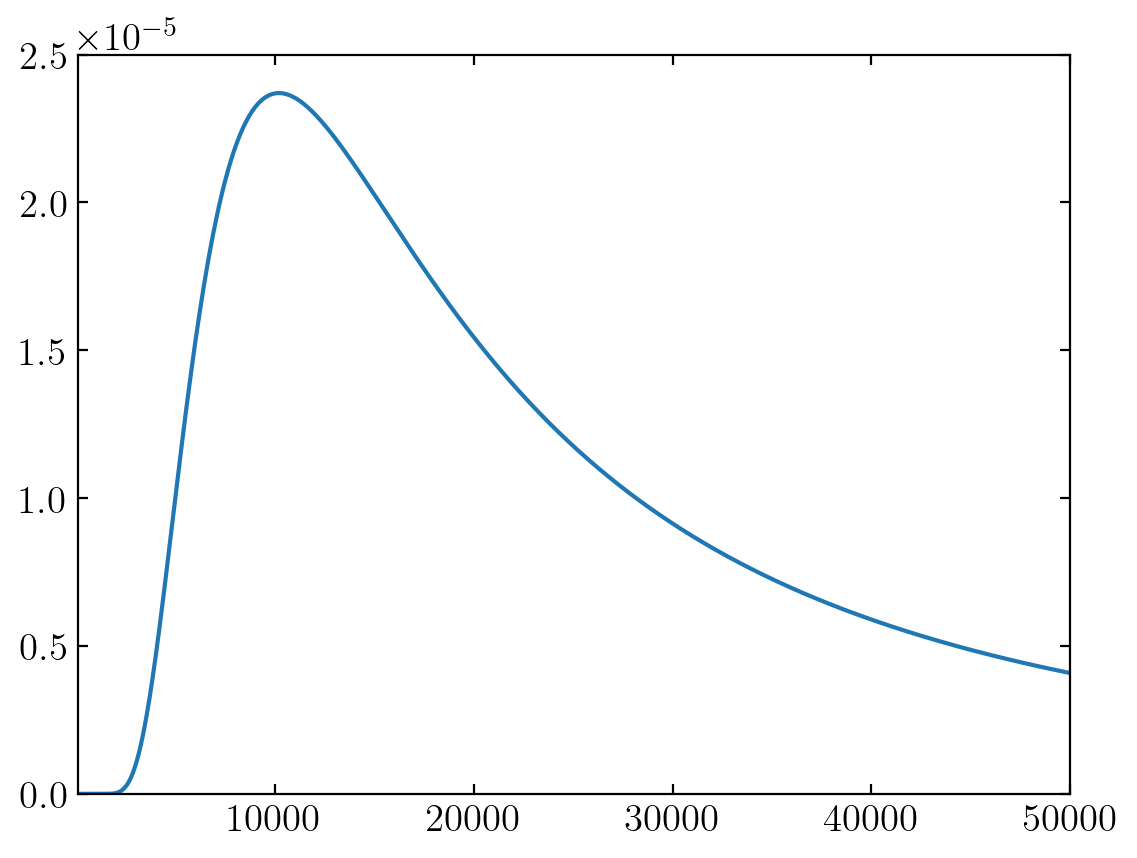

In [3]:
bb = BlackBody(temperature=5000*u.K)
lambd = np.linspace(100 ,int(5e4), 1000)
plt.plot(lambd, bb(lambd * u.AA))
plt.ylim(0, 2.5e-5);

We need the lifetime of the star, we find that $\tau \sim M^{-2}$

In [4]:
def spmodel(m_arr, lambd, age_g):
    bb_tot = 0
    
    for m in m_arr:
        T = 5780*(m**0.5)
        L = m**3.5          #luminosity because distance is the same and it's just a scale factor
        nstars = m**(-2.35)
        lifetime_s = m/L
        
        if age_g <= lifetime_s:
            b0 = BlackBody(temperature=T*u.K, scale = 1.*u.erg/(u.cm**2 * u.AA * u.s * u.sr))
            bb = L*nstars*b0(lambd * u.AA)/(b0.bolometric_flux.value)  #stars at the same distance
            bb_tot += bb
            
    return bb_tot/bb_tot[lambd == 5500]

In [5]:
m_min = 0.1
m_max = 100
nbin = 1000
xi_0 = 1 # density of stars in galaxy

m_arr = np.linspace(m_min, m_max, nbin)

The peak of the spectrum is at 5860 K


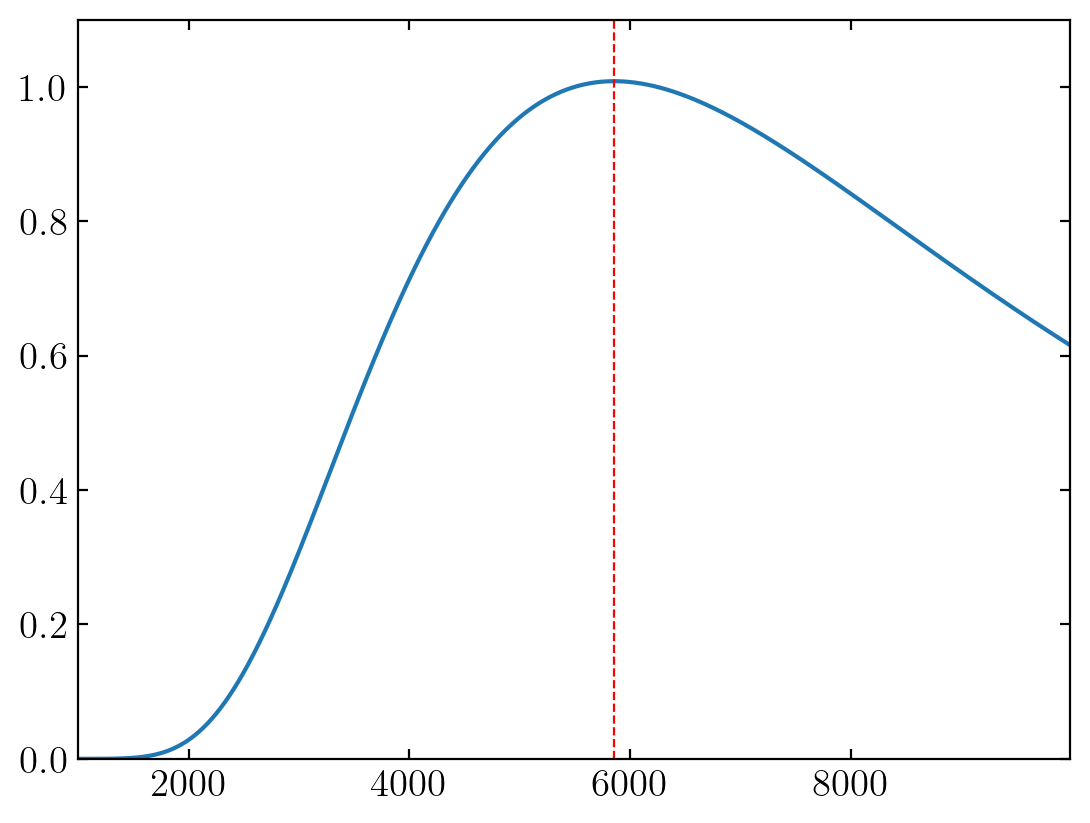

In [6]:
lambd = np.arange(int(1e3) ,int(1e4), 10)
y = spmodel(m_arr, lambd, 1)

plt.plot(lambd, y)
max_l = lambd[np.argmax(y)]
plt.axvline(max_l, color = 'red', linestyle = 'dashed', lw = .8)
plt.ylim(0, 1.1);

print('The peak of the spectrum is at', max_l, 'K')

  0%|          | 0/5 [00:00<?, ?it/s]

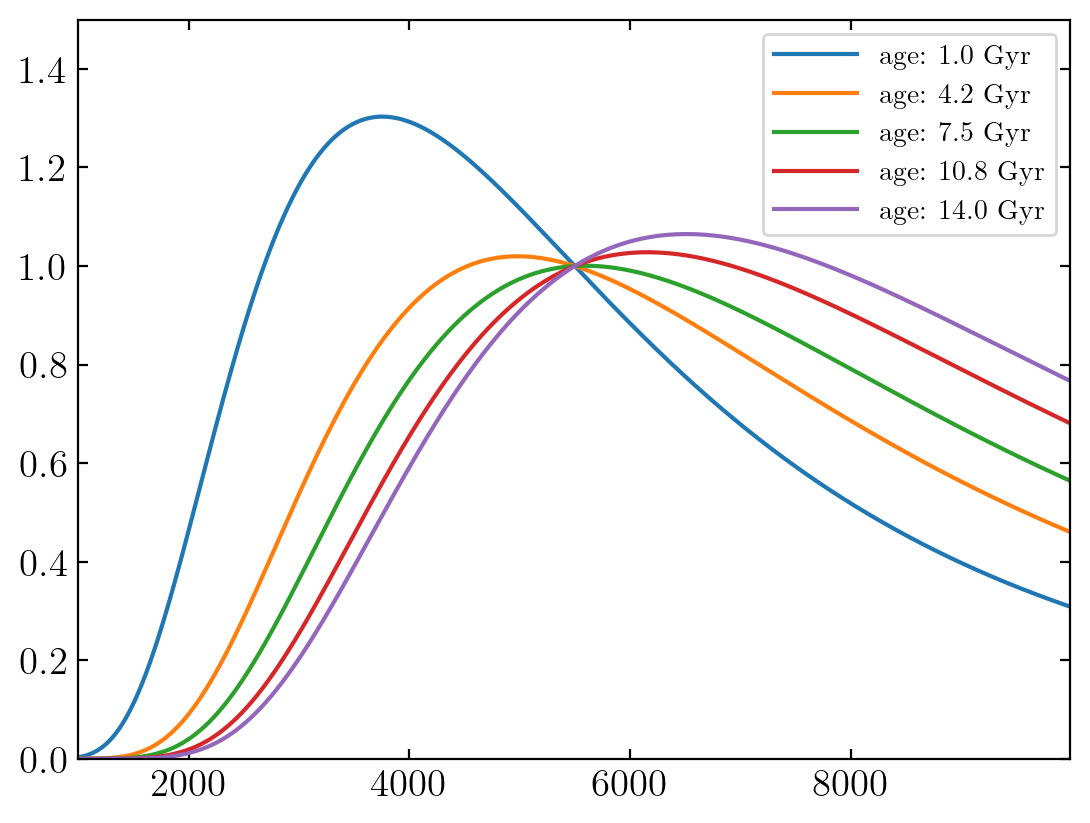

In [7]:
from tqdm.notebook import tqdm

lambd = np.arange(int(1e3), int(1e4), 10)
age_arr = np.linspace(0.1, 1.4, 5)
# the age is normalized to the age of the sun, which is 10 Gyr


for t in tqdm(age_arr):
    y = spmodel(m_arr, lambd, t)
    plt.plot(lambd, y, label = f'age: {round(t*10,1)} Gyr')
    
plt.legend(loc = 'upper right', fontsize = 10)
plt.ylim(0,1.5);

G1 is 1.9 $\text{Gyr}$ old. <br>
G2 is 3 $\text{Gyr}$ old. <br>
G3 is 14 $\text{Gyr}$ old. <br>

### Observations
<img src= "Material/G3.png" align = right width = 400px>

How do you define the peak in the G3 galaxy spectrum? You could do it in two ways
- You could define a range of maxima and give an estimate of the age
- You smoothen the spectrum, you use your model and interpolate the data and try to find the maximum this way

There is a broad agreement on the shape of the code, we will use ir as reference for the moment.

If i now want to rescale the spectrum so that it matches with my model, what can i measure by comparing the two? The mass of one star, so the normalization of the spectrum will give me the total mass of the galaxy since it is the integral of that.

You can measure stellar masses and stellar ages with these assumptions, can we relax some of them? We need to **test** them

---

# Reviewing assumptions
We assumed that the observed spectra and the emitted spectra are the same but the galaxy has a few mediums in between us and it, for example:
- Interstellar dust
- Gas
- Star atmosphere

The dust is particularly important because it is opaque to optical light, there is always presence of dust so we *need* to take into account.

### Dust attenuation
We have assumed that the intrinsic flux is the observed flux, that is the case only if there is no dust. The dust *attenuates* light from the incoming source and does so exponentially.

$$ f_\text{obs}(\lambda) = f_\text{int}(\lambda) \ 10^{-0.4 A_\lambda} \qquad A_\lambda = k(\lambda)\ E(B-V)$$

Now, the 0.4 coefficient is due to magnitude conversion. The $E$ stands for the *color excess*. The $\lambda$ is given in microns
<img src="Material/dust.png" width = 800 px align=center>

Look at the images, you find that most of the absorption is at the disk. So you need two things, you need the map of the absorption and also the value of $k(\lambda)$ which depends on the dust properties. <br>
There are many empirical models described, we will used the Calzetti Star Burst (SB), its law is the following
<img src="Material/kmodel.png" width = 500 px>

Now you can correct your spectrum, you have everything but one free parameter $E(B-V)$ so you have to assume this, you can see how the spectrum changes with the color excess. If i look at the galaxy face on $E = 0$ because i have no dust, if instead i have it edge on $E = 1$ so it's maximum

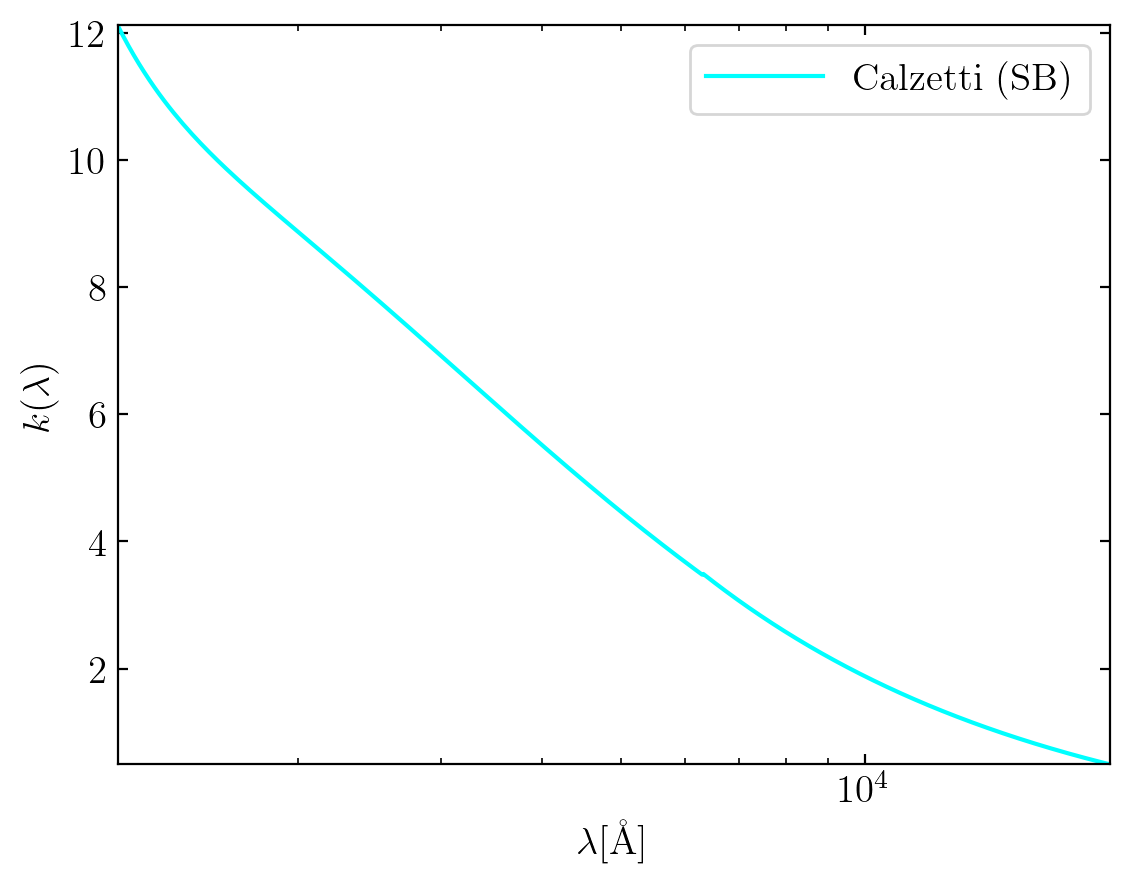

In [8]:
#opacity
lambd1 = np.linspace(1.2e3, 2*1e4, 1000)

def k(lambd):
    lambd = lambd/1e4
    k_ = [] 
    
    for l in lambd:
        if (l >= 0.12 and l <= 0.63):
            k_.append(2.659*(-2.156 + 1.509/l - 0.198/l**2 + 0.011/l**3) + 4.05)
        elif (l > 0.63 and l <= 2.20):
            k_.append(2.659*(-1.857 + 1.040/l) + 4.05)
        else:
            k_.append(0)
    
    return np.array(k_)

plt.plot(lambd1, k(lambd1), label = "Calzetti (SB)", color = 'cyan')
plt.xscale('log')
plt.xlabel(r'$\rm\lambda[\AA]$')
plt.ylabel(r'$k(\lambda)$')

plt.legend();

In [52]:
def attenuation(f_int, lambd, E):
    A_l = k(lambd)*E
    A_5500 = A_l[lambd == 9000]
    
    return f_int*10**(-0.4*(A_l-A_5500))

In [53]:
def spmodel(m_arr, lambd, age_g):
    bb_tot = 0
    
    for m in m_arr:
        T = 5780*(m**0.5)
        L = m**3.5          #luminosity because distance is the same and it's just a scale factor
        nstars = m**(-2.35)
        lifetime_s = m/L
        
        if age_g <= lifetime_s:
            b0 = BlackBody(temperature=T*u.K, scale = 1.*u.erg/(u.cm**2 * u.AA * u.s * u.sr))
            bb = L*nstars*b0(lambd * u.AA)/(b0.bolometric_flux.value)  #stars at the same distance
            bb_tot += bb
            
    return bb_tot/bb_tot[lambd == 9000]

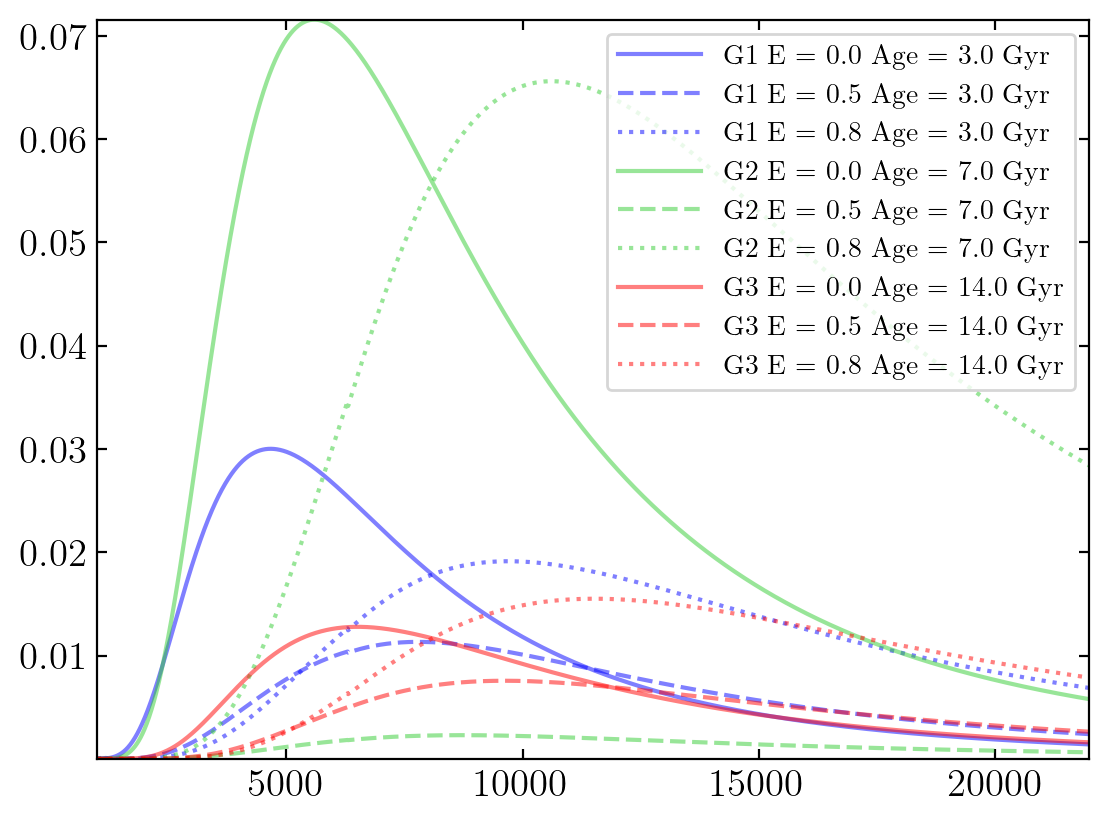

In [55]:
m_min = 0.1
m_max = 100
nbin = 1000
xi_0 = 1 # density of stars in galaxy
m_arr = np.linspace(m_min, m_max, nbin)

E_arr = np.array([0, .5, .8])
age_arr = np.array([.3,.7,1.4])

lambd = np.arange(int(1e3) ,int(2.2e4), 10)

colors = ['blue', 'limegreen', 'red']
linestyles = ['-', '--', ':']
G = ['G1', 'G2', 'G3']

for age_g, cl, g in zip(age_arr, colors, G):
    f_int = spmodel(m_arr, lambd, age_g)
    
    for E, ls in zip(E_arr, linestyles):
        f_obs = attenuation(f_int, lambd, E)/f_obs[lambd==5500]
        plt.plot(lambd, f_obs, label=f"{g} E = {round(E, 2)} Age = {age_g*10} Gyr", color = cl, ls = ls, alpha = .5)

plt.legend(fontsize = 10)

Where $E$ indicates the attenuation parameter due to the dust, $E \in [0,1]$

### Conclusions
We have a degeneracy on the two variables `age_gal` and $E$, this means that a galaxy like G3 could be a young star with a high $E$.

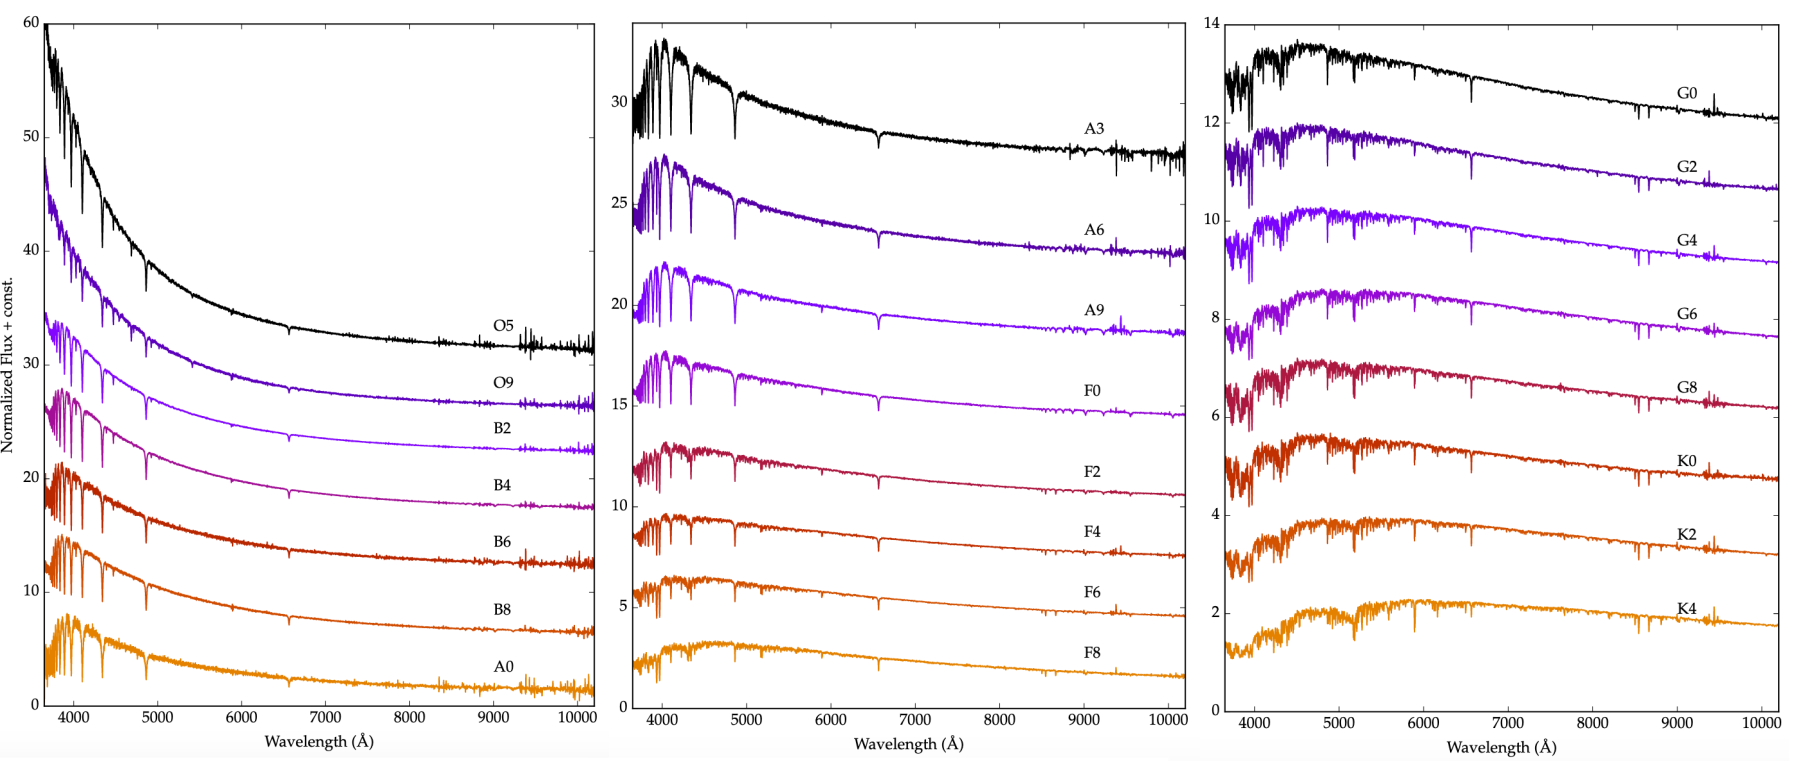


Here we show the spectra of stars, you can see that the $\text{O}$ stars are peaked in blue and colder stars move towards the red, but **something interesting happens**.

Stars around $\text{B4-B5}$ present the balmer series absorption lines, because they are cold enough to host them. Stars around $\text{K4}$ don't have balmer absorption lines but other absorption lines, so now **we can use them as thermometers** and since we know how to determine the galaxy age, we can infer the age from there.

# Actual age of the galaxies
- Line break at $410\ nm$ for the Balmer series
- Line break at $1094\ nm$ for the Paschen series (we can't see it in the optical), maybe it's Helium

G3 = G6 <br>
G2 = F6-F4 <br>
G1 = F2<br>

The absorption lines are the *fingerprint* of the galaxy.

### What about the emission lines?
- G1 and G2 present $\text{H-}\alpha$ emission at $656.3\ nm$
- G3 has no absorption lines

The emission processes are
- Collisional excitation
- Recombination

**Our theory**
*G1 and G2 gasses are excited due to the presence of young stars that peak more in the UV, this causes the gas to excite thanks to recombination and produce the $\text{O}$ and $\text{H}$ emission lines. This means that **G1 should be younger than G2** since the incoming radiation is energetic enough to excite Helium too.<br>
Meanwhile G3 could don't emit since the stars are not energetic enough to ionize the gas but only to warm it up and cause collisions of atoms.*

In [12]:
#SI
h = 6.63e-34
c = 3e8
E = 25.6*1.6022e-19

lambda1 = h*c/E
print(round(lambda1*10**10,2))

484.93


#### How can we infer the star formation rate from the line emission intensity?
The flux depends on a few things, like the number of photons emitting, which depend on the number of photons irradiating my gas, which depend on **the number of OB stars in the galaxy**.

So the G1 galaxy has a very intense $\text{H-}\alpha$ emission, which means that the star formation rate of OB stars is very high at the time of observation.<br>
The G2 galaxy is still producing OB stars but less of them and the G3 galaxy has stopped producing them.

So the G1 is younger, the G2 is middle aged, the G3 is older. As a rough first estimate:

- G1 $\in$ [1, 2] Gyrs
- G2 $\in$ [2, 5] Gyrs
- G3 $\geq$ 10 Gyrs

<img src="Material/G1.png" width = 300 px align=left>
<img src="Material/G2.png" width = 300 px align=left>
<img src="Material/G3.png" width = 300 px align=left>

# Fitting our model to the data
In this section we are trying to estimate the $M_{tot}$ of $S1$, $S2$, $S3$ and $S4$ galaxies' fluxes. I am gonna here report some notes (star formation parts excluded) taken during the lectures.

The previous lab-session we have neglected the constant $\xi_0$ that was present in the calculation of Salpeter's IMF: 

$$dN = \xi_0 M^{-2.35} dM$$

If we evaluate it in terms of the $M_{tot}$ of the galaxy, it's gonna be easy to integrate it in our $\textbf{SP_Model}$ calculation of the BB superposition. Basically we just have to integrate over the chosen mass range: 


$$M_{tot} = \int_{M_{min}}^{M_{max}} M dN = \int_{M_{min}}^{M_{max}} \xi_0 M^{-1.35} dM = \frac{1}{-0.35}\ \xi_0 (M_{max}^{-0.35} - M_{min}^{-0.35})$$ 

returning 

$$\xi_0 = - \frac{0.35\ M_{tot}}{(M_{max}^{-0.35} - M_{min}^{-0.35})}$$ 


This value will correct the BB spectrum.


We first need to fetch the data from `.fits` files. 

In [13]:
from astropy.io import fits
import glob

In [14]:
filenames=glob.glob('./S/S*.fits')
filenames.reverse()
print(filenames)

['./S/S4.fits', './S/S3.fits', './S/S2.fits', './S/S1.fits']


In [15]:
filenames = filenames[::-1]
print(filenames)

['./S/S1.fits', './S/S2.fits', './S/S3.fits', './S/S4.fits']


In [16]:
data = {}

for i in range(1, 5): 
    data[f"S{i}"] = fits.open(filenames[i - 1])   #i have to store data in dictionary because fits.open gives objects

In [17]:
s1_data = data["S1"][1].data
s2_data = data["S2"][1].data
s3_data = data["S3"][1].data
s4_data = data["S4"][1].data

In [18]:
import pandas as pd
display(pd.DataFrame(s1_data))

,flux,loglam,ivar,and_mask,or_mask,wdisp,sky,model
0,10.525585,3.5823,0.084046,0,1048576,1.130101,8.763886,13.983377
1,15.177439,3.5824,0.081763,0,0,1.129744,8.903050,14.195063
2,15.572576,3.5825,0.079459,0,0,1.129389,9.045424,14.802118
3,11.552800,3.5826,0.082240,0,0,1.129033,8.631663,15.455320
4,11.813586,3.5827,0.082414,0,0,1.128678,7.910803,15.391591
...,...,...,...,...,...,...,...,...
3813,5.921316,3.9636,1.310035,0,0,0.674149,3.715196,5.944695
3814,7.293791,3.9637,1.235303,0,0,0.674009,3.755620,5.944907
3815,5.772647,3.9638,1.330629,0,0,0.673868,3.818559,5.945120
3816,6.816389,3.9639,1.325924,0,0,0.673728,3.860369,5.945333


# S1

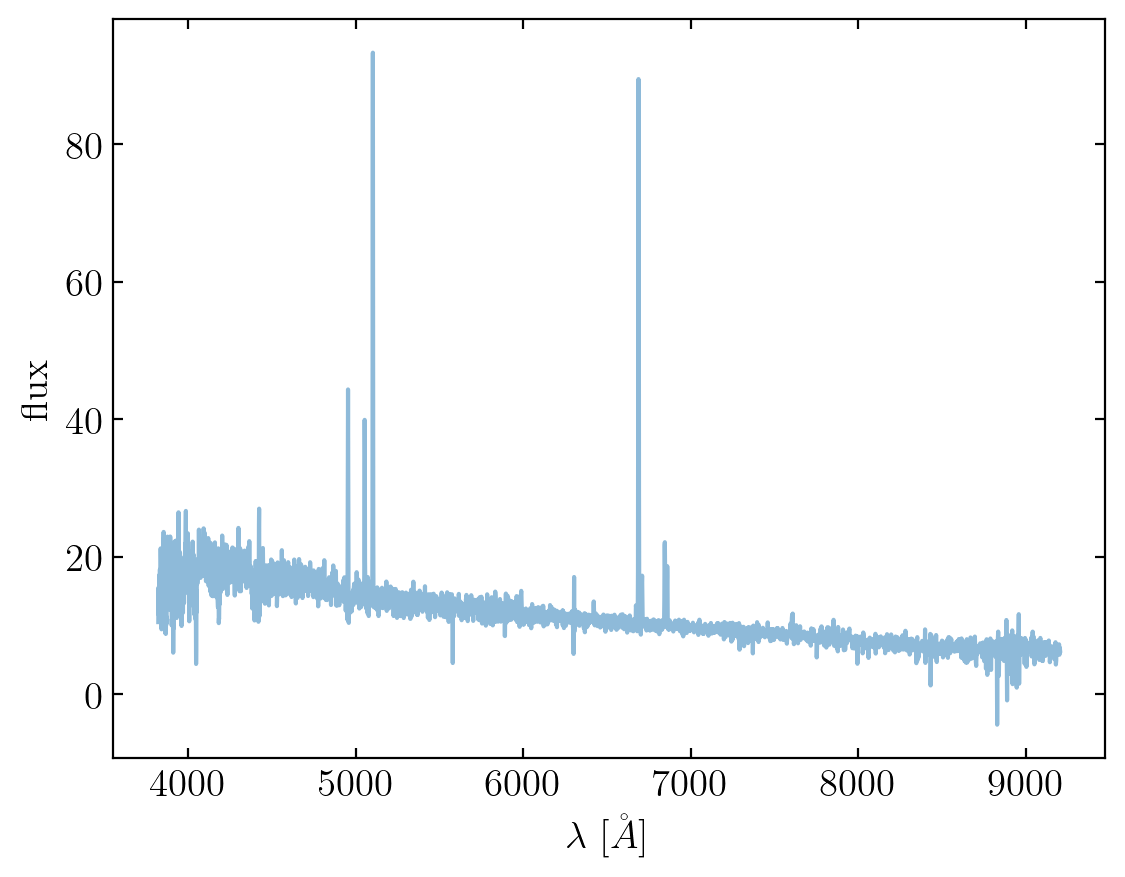

In [19]:
s1_flux = s1_data['flux']
s1_log_lam = s1_data['loglam']

plt.plot(10 ** s1_log_lam, s1_flux, alpha = .5)
plt.margins(.05)
plt.xlabel(r'$\lambda \ [\AA]$')
plt.ylabel('flux')
plt.show(); 

We would like to convert the flux we have here in terms of a $\textit{specific luminosity}$, which is the output of our $\textbf{SP_Model}$ above, in order to compare the two. First we need to know how redshifted the galaxy is so that we can extrapolate the $\textit{luminosity distance}$. 

In [20]:
import numpy.ma as ma

s1_wav_arr = np.array(10 ** s1_log_lam)
s1_region=ma.masked_inside(s1_wav_arr,6500,7000)

redshifted_H_alpha = s1_wav_arr[np.where(s1_flux == np.max(s1_flux[s1_region.mask]))][0]
theor_H_alpha = 6564.6  # AA

s1_z = (redshifted_H_alpha - theor_H_alpha) / redshifted_H_alpha

print(s1_z)

0.018459341259610254


Using `astropy` to get the luminosity distance: 

In [21]:
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

In [22]:
s1_dist=cosmo.luminosity_distance(s1_z).to(u.cm)

In [23]:
s1_lum=4 * np.pi * (s1_dist**2) * s1_flux*10**(-17) * (1 + s1_z)**2  # 10^-17 is the units of flux from datafile

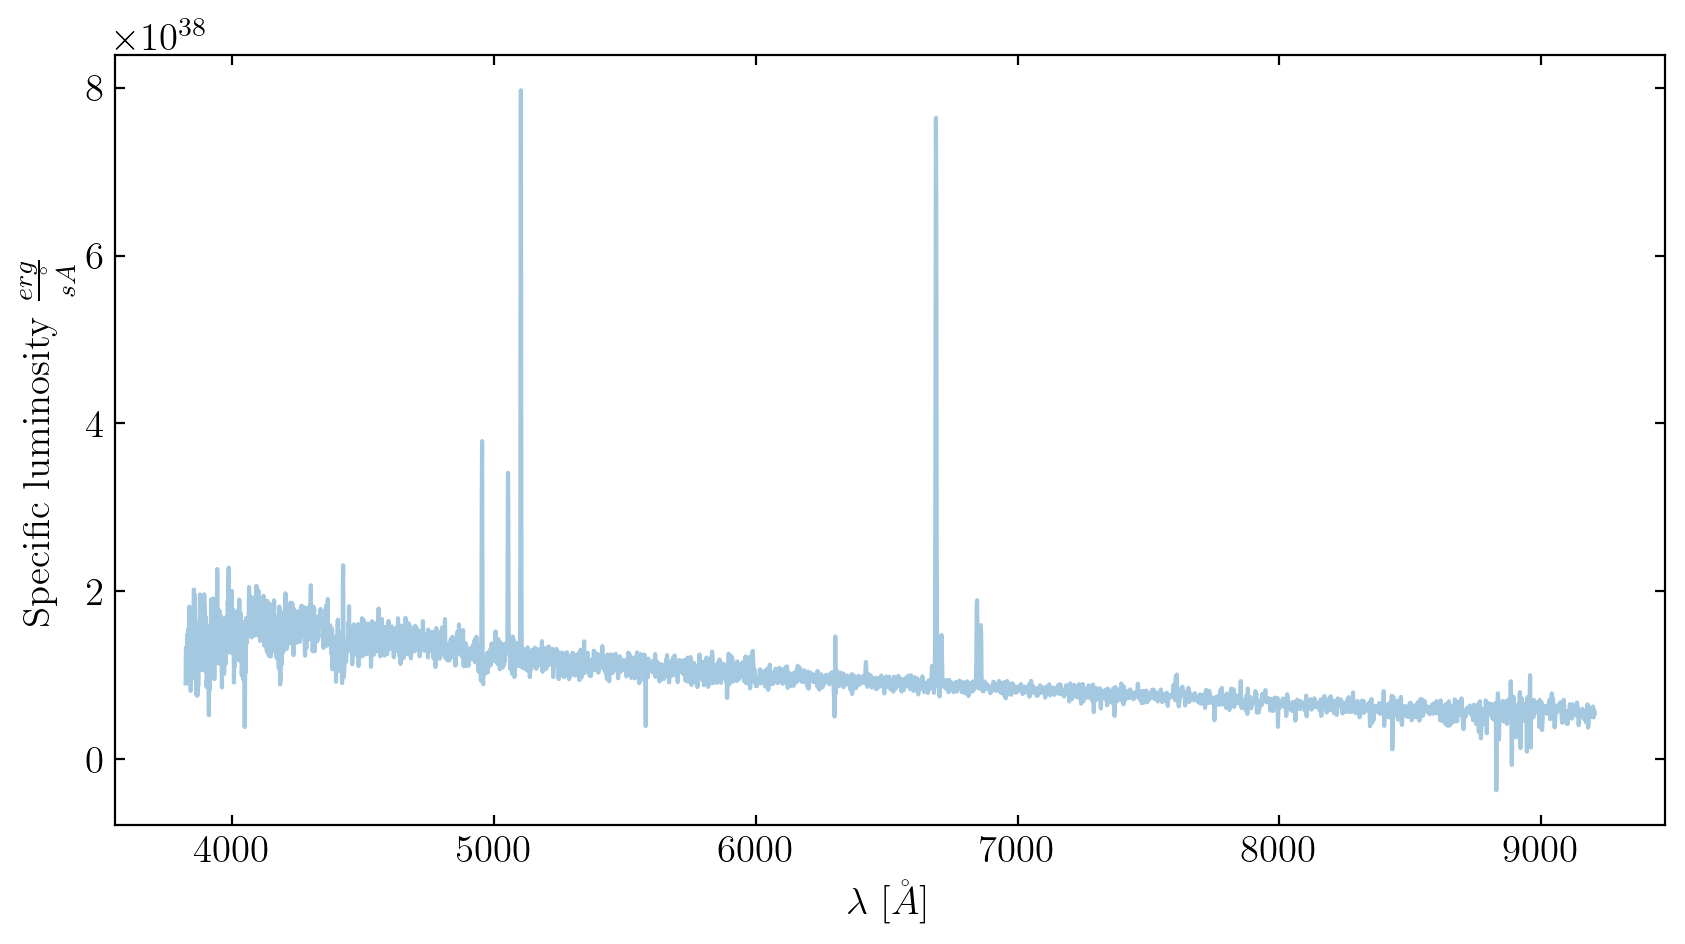

In [24]:
plt.figure(figsize=(10,5))
plt.plot(s1_wav_arr, s1_lum, alpha = .4)

plt.xlabel(r'$\lambda\ [\AA]$')
plt.ylabel(r'Specific luminosity  $\frac{erg}{s \AA}$')
plt.margins(.05)
plt.show();

In [25]:
np.savetxt('S1.txt', (s1_wav_arr, s1_lum))

Let's have a check on this! We know that from the spectrum we see that the galaxy is young, so we will probe only small $t_{gal}$ parameters (also because otherwise we have a degeneration: older galaxy but smaller mass or the opposite). 

In [26]:
def spmodel_eps(m_arr, lambd, age_g, m_tot):
    bb_tot = 0
    
    #now with epsilon
    alpha = 2.35
    epsilon_0 = (2 - alpha) * m_tot / (np.max(m_arr)**(2-alpha) - np.min(m_arr)**(2-alpha))

    for m in m_arr:
        T = 5780*(m**0.5)
        L = m**3.5          #luminosity because distance is the same and it's just a scale factor
        nstars = m**(-2.35)
        lifetime_s = m/L
        
        if age_g <= lifetime_s:
            
            b0 = BlackBody(temperature=T*u.K, scale = 1.*u.erg/(u.cm**2 * u.AA * u.s * u.sr))
            bb = epsilon_0 * m**(1.15)*b0(lambd * u.AA)/(b0.bolometric_flux.value)  #stars at the same distance
            bb_tot += bb
            
    return bb_tot

In [27]:
def Lum(lambd, gal_age, M_tot):
    m_min = 0.1
    m_max = 100
    nbin = 1000
    xi_0 = 1 # density of stars in galaxy
    m_arr = np.linspace(m_min, m_max, nbin)
    
    flux = spmodel_eps(m_arr, lambd, gal_age, M_tot)
    
    return np.array(flux.value*4*np.pi*4 * 10**33, dtype=float)

In [29]:
from scipy.optimize import curve_fit

s1_wav_arr = np.array(s1_wav_arr, dtype = float)
s1_lum = np.array(s1_lum, dtype = float)

p, _ = curve_fit(Lum, s1_wav_arr, s1_lum)

print(p)

[7.83290400e-01 2.07580515e+07]


/home/sam/miniconda3/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


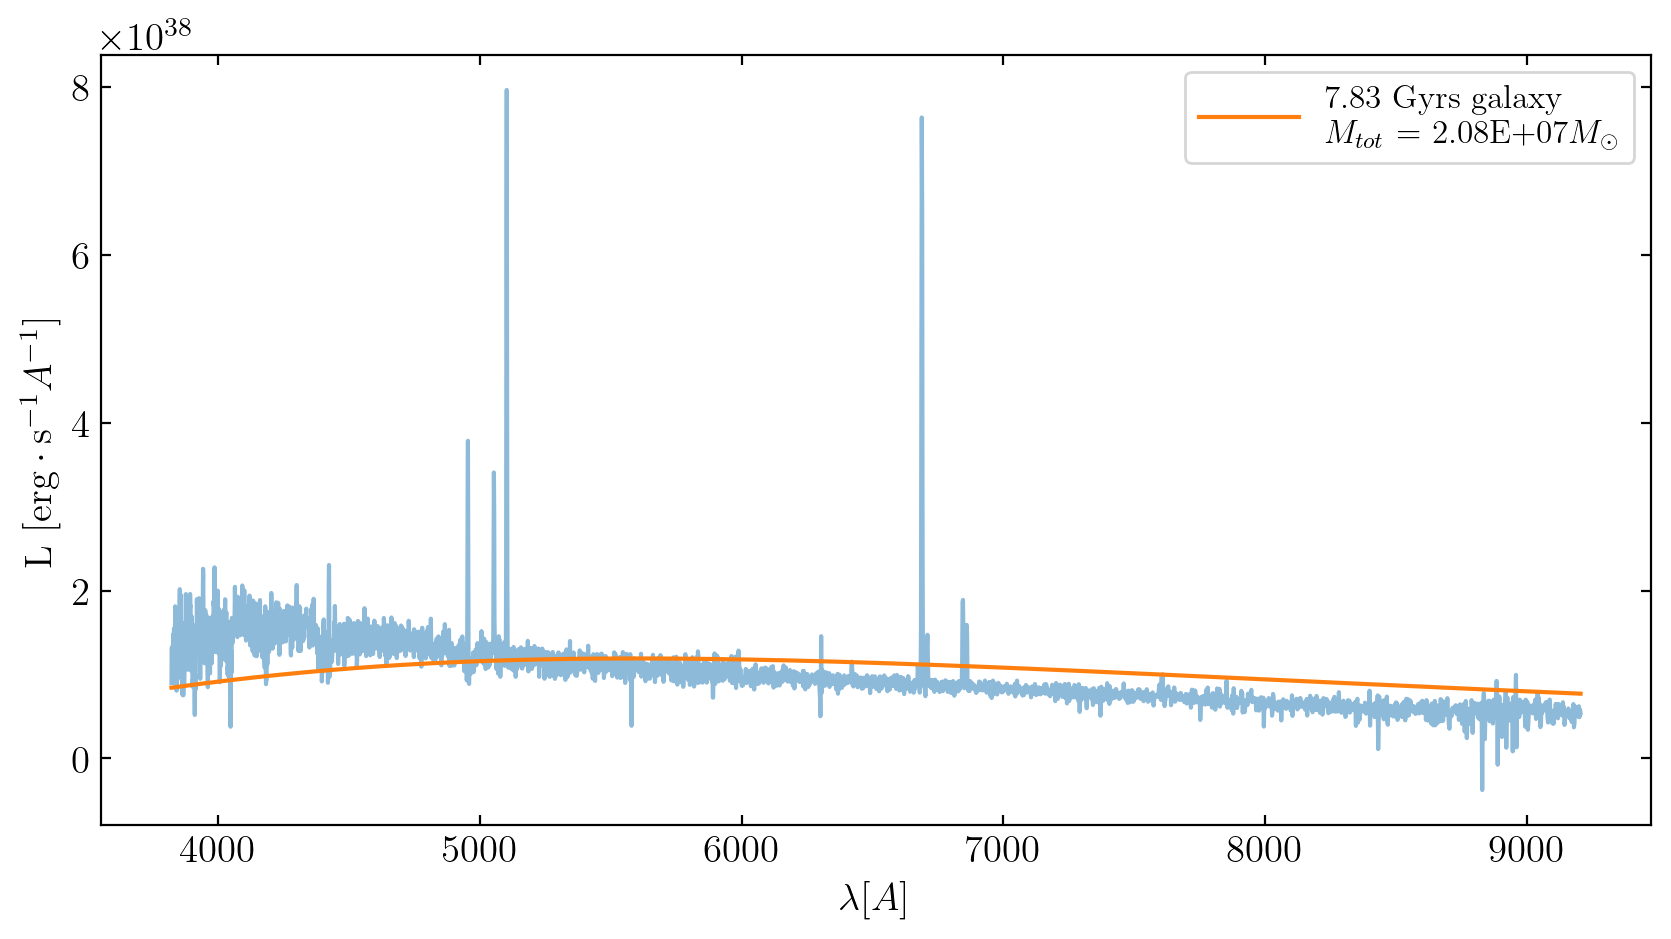

In [30]:
y_pred = Lum(s1_wav_arr, p[0], p[1])

plt.figure(figsize=(10, 5))
plt.plot(s1_wav_arr, s1_lum, alpha = .5)
plt.plot(s1_wav_arr, y_pred, label= "%.2f Gyrs galaxy \n" % (p[0]*10) + "$M_{tot}$ = %.2E" % p[1] + "$M_{\odot}$")  # solar L

plt.xlabel("$\lambda [A]$")
plt.ylabel("L [$\mathrm{erg}\cdot \mathrm{s}^{-1} A^{-1}$]")
plt.legend(loc = 'upper right', fontsize = 12)
plt.margins(.05)
plt.show();

# S2

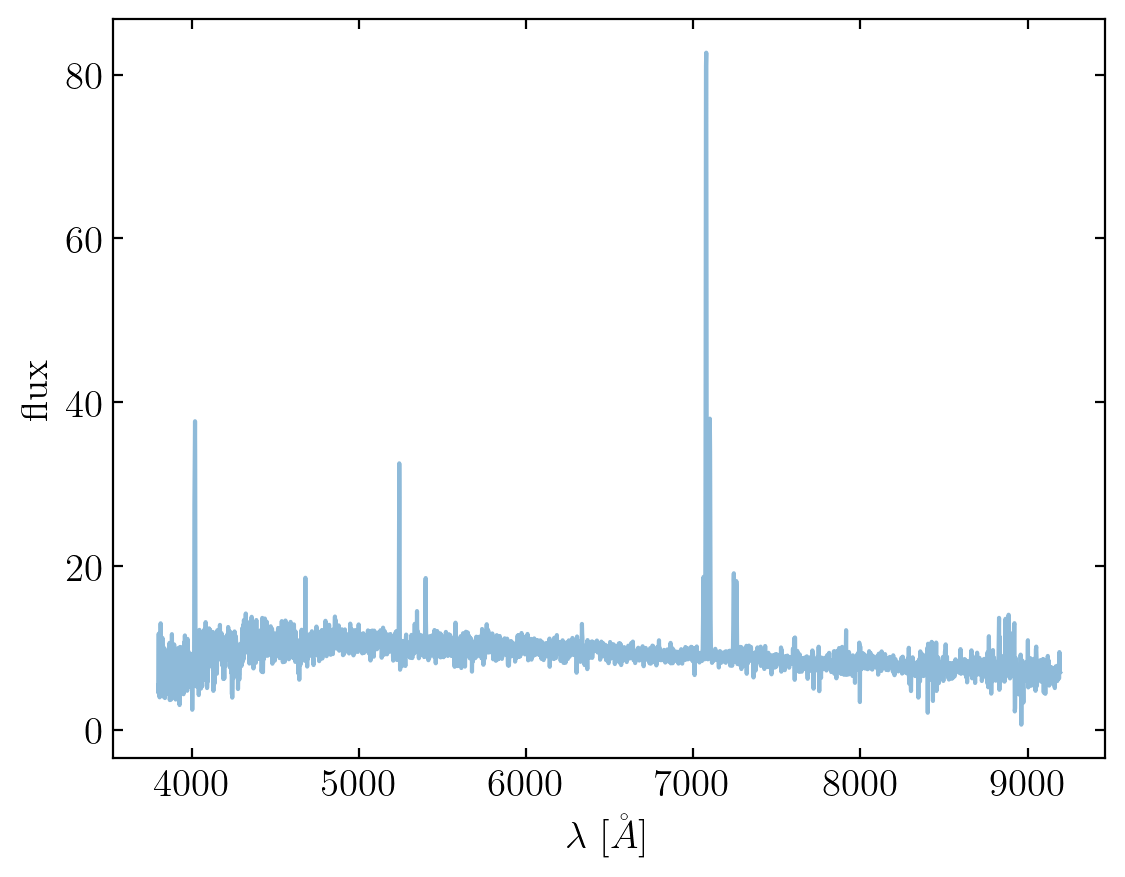

In [31]:
s2_flux = s2_data['flux']
s2_log_lam = s2_data['loglam']

plt.plot(10 ** s2_log_lam, s2_flux, alpha = .5)
plt.margins(.05)
plt.xlabel(r'$\lambda \ [\AA]$')
plt.ylabel('flux')
plt.show(); 

In [32]:
s2_wav_arr = np.array(10 ** s2_log_lam)
s2_region=ma.masked_inside(s2_wav_arr,6500,7000)

redshifted_H_alpha = s2_wav_arr[np.where(s2_flux == np.max(s2_flux[s2_region.mask]))][0]
theor_H_alpha = 6564.6  # AA

s2_z = (redshifted_H_alpha - theor_H_alpha) / redshifted_H_alpha

In [33]:
s2_dist=cosmo.luminosity_distance(s2_z).to(u.cm)
s2_lum=4 * np.pi * (s2_dist**2) * s2_flux*10**(-17) * (1 + s2_z)**2  # 10^-17 is the units of flux from datafile

In [34]:
np.savetxt('S2.txt', (s2_wav_arr, s2_lum))

In [35]:
from scipy.optimize import curve_fit

s2_wav_arr = np.array(s2_wav_arr, dtype = float)
s2_lum = np.array(s2_lum, dtype = float)

p, _ = curve_fit(Lum, s2_wav_arr, s2_lum)

print(p)

[7.07896076e-01 5.67792320e+07]


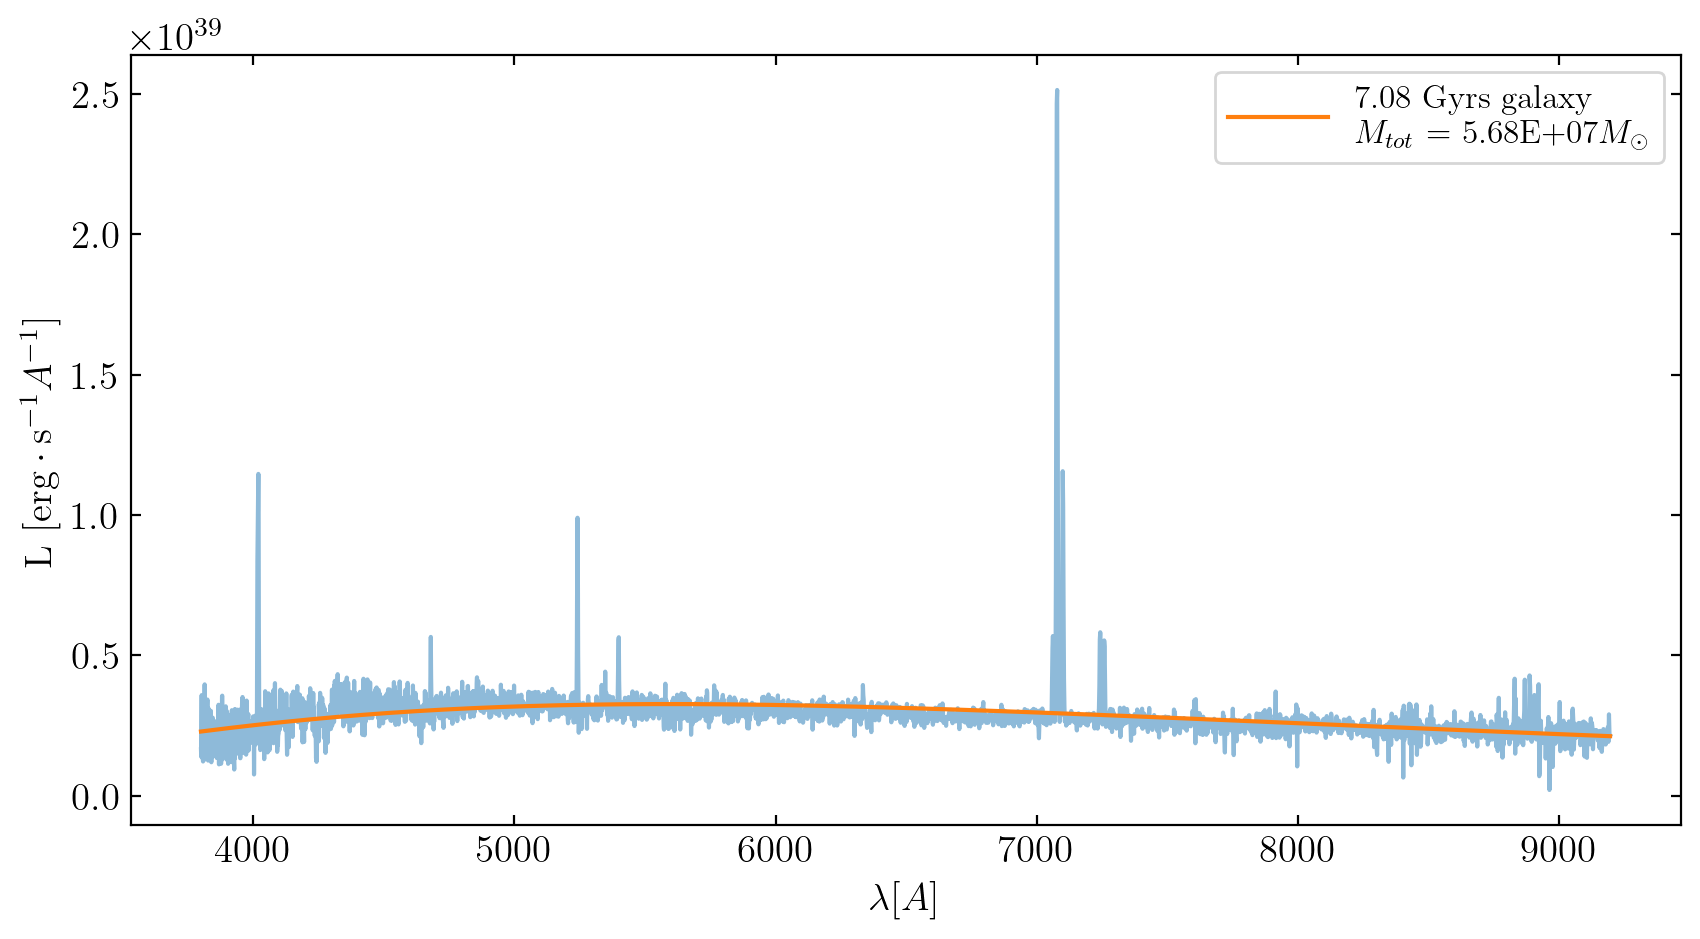

In [36]:
y_pred = Lum(s2_wav_arr, p[0], p[1])

plt.figure(figsize=(10, 5))
plt.plot(s2_wav_arr, s2_lum, alpha = .5)
plt.plot(s2_wav_arr, y_pred, label= "%.2f Gyrs galaxy \n" % (p[0]*10) + "$M_{tot}$ = %.2E" % p[1] + "$M_{\odot}$")  # solar L

plt.xlabel("$\lambda [A]$")
plt.ylabel("L [$\mathrm{erg}\cdot \mathrm{s}^{-1} A^{-1}$]")
plt.legend(loc = 'upper right', fontsize = 12)
plt.margins(.05)
plt.show();

# S3

In [37]:
s3_flux = s3_data['flux']
s3_log_lam = s3_data['loglam']

s3_wav_arr = np.array(10 ** s3_log_lam)
s3_region=ma.masked_inside(s3_wav_arr,6500,7000)

redshifted_H_alpha = s3_wav_arr[np.where(s3_flux == np.max(s3_flux[s3_region.mask]))][0]
theor_H_alpha = 6564.6  # AA

s3_z = (redshifted_H_alpha - theor_H_alpha) / redshifted_H_alpha

s3_dist=cosmo.luminosity_distance(s3_z).to(u.cm)
s3_lum=4 * np.pi * (s3_dist**2) * s3_flux*10**(-17) * (1 + s3_z)**2  # 10^-17 is the units of flux from datafile

In [38]:
np.savetxt('s3.txt', (s3_wav_arr, s3_lum))

In [39]:
from scipy.optimize import curve_fit

s3_wav_arr = np.array(s3_wav_arr, dtype = float)
s3_lum = np.array(s3_lum, dtype = float)

p, _ = curve_fit(Lum, s3_wav_arr, s3_lum)

print(p)

[1.07460267e+00 4.47201424e+06]


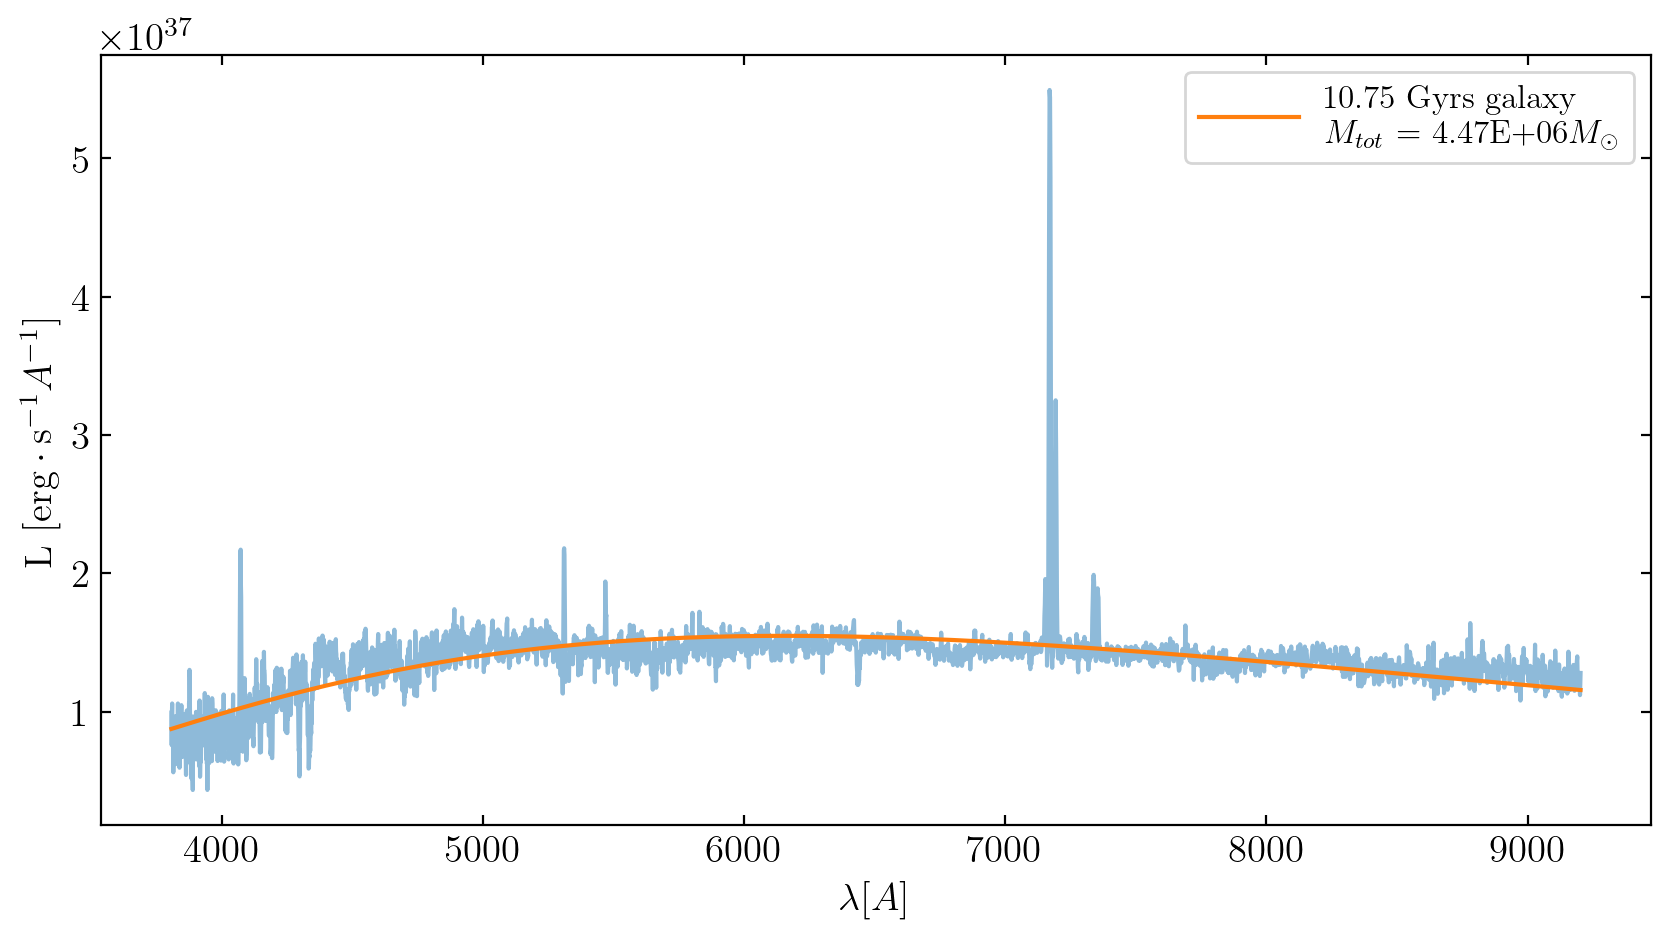

In [40]:
y_pred = Lum(s3_wav_arr, p[0], p[1])

plt.figure(figsize=(10, 5))
plt.plot(s3_wav_arr, s3_lum, alpha = .5)
plt.plot(s3_wav_arr, y_pred, label= "%.2f Gyrs galaxy \n" % (p[0]*10) + "$M_{tot}$ = %.2E" % p[1] + "$M_{\odot}$")  # solar L

plt.xlabel("$\lambda [A]$")
plt.ylabel("L [$\mathrm{erg}\cdot \mathrm{s}^{-1} A^{-1}$]")
plt.legend(loc = 'upper right', fontsize = 12)
plt.margins(.05)
plt.show();

# S4

In [41]:
s4_flux = s4_data['flux']
s4_log_lam = s4_data['loglam']

s4_wav_arr = np.array(10 ** s4_log_lam)
s4_region=ma.masked_inside(s4_wav_arr,6500,7000)

redshifted_H_alpha = s4_wav_arr[np.where(s4_flux == np.max(s4_flux[s4_region.mask]))][0]
theor_H_alpha = 6564.6  # AA

s4_z = (redshifted_H_alpha - theor_H_alpha) / redshifted_H_alpha

s4_dist=cosmo.luminosity_distance(s4_z).to(u.cm)
s4_lum=4 * np.pi * (s4_dist**2) * s4_flux*10**(-17) * (1 + s4_z)**2  # 10^-17 is the units of flux from datafile

In [42]:
np.savetxt('S4.txt', (s4_wav_arr, s4_lum))

In [43]:
from scipy.optimize import curve_fit

s4_wav_arr = np.array(s4_wav_arr, dtype = float)
s4_lum = np.array(s4_lum, dtype = float)

p, _ = curve_fit(Lum, s4_wav_arr, s4_lum)

print(p)

[1.56031347e+00 1.15928068e+07]


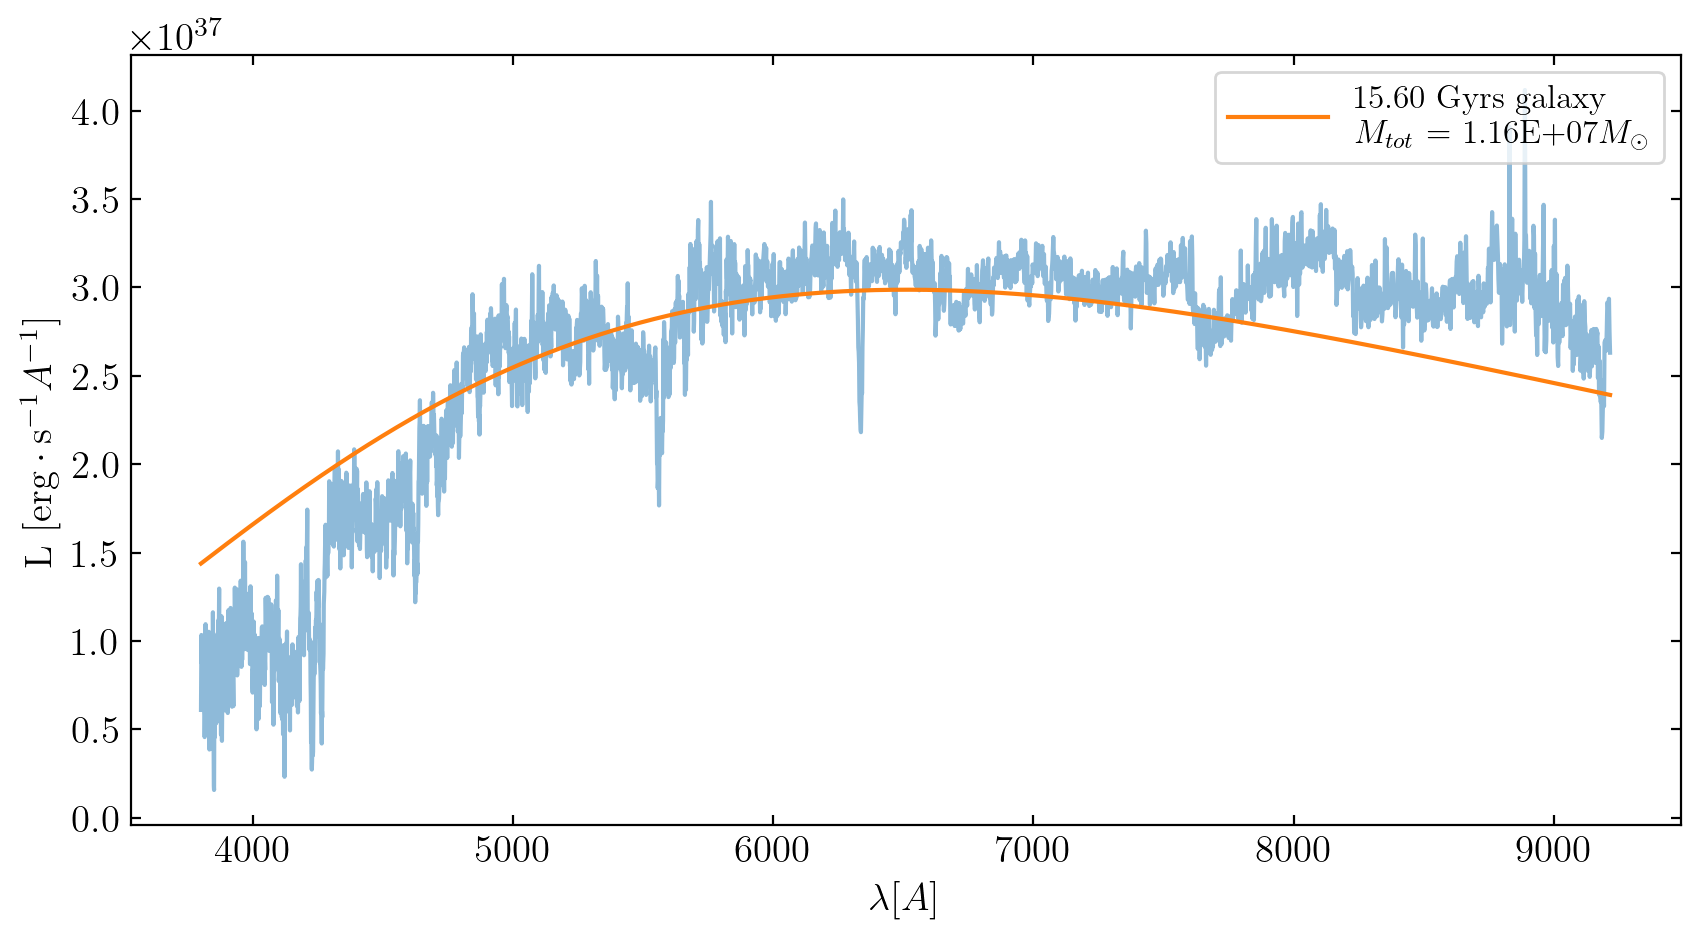

In [44]:
y_pred = Lum(s4_wav_arr, p[0], p[1])

plt.figure(figsize=(10, 5))
plt.plot(s4_wav_arr, s4_lum, alpha = .5)
plt.plot(s4_wav_arr, y_pred, label= "%.2f Gyrs galaxy \n" % (p[0]*10) + "$M_{tot}$ = %.2E" % p[1] + "$M_{\odot}$")  # solar L

plt.xlabel("$\lambda [A]$")
plt.ylabel("L [$\mathrm{erg}\cdot \mathrm{s}^{-1} A^{-1}$]")
plt.legend(loc = 'upper right', fontsize = 12)
plt.margins(.05)
plt.show();